In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

from scipy.linalg import eigh

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Use LaTeX for rendering (comment of not needed)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Text(0, 0.5, 'Overlap $m$')

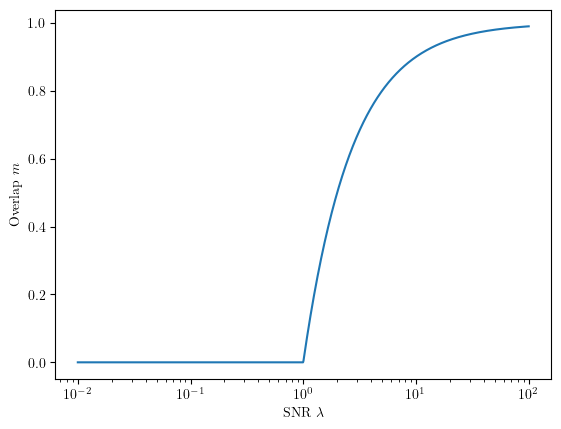

In [38]:
lambd = np.logspace(-2, 2, 1024)

plt.plot(lambd, np.maximum(0, 1 - 1/lambd))
plt.xscale('log')
plt.xlabel(r"SNR $\lambda$")
plt.ylabel(r"Overlap $m$")

### State evolution sparse

Explore the dependency of $\rho$ on the error vs snr curves. In particular find a $\rho$ for which a hard phase exists

In [14]:
def gaussian_pdf(x, mean = 0, variance = 1):
    '''
    Gaussian measure.
    '''
    return np.exp(-.5 * (x-mean)**2 / variance) / np.sqrt(2*np.pi*variance)

In [32]:
# State evolution 
def update_m(m:float,snr,rho:float, lims=10):
    '''
    One step updated of the self-consistent equation for spiked matrix estimation using the given prior
    '''
    integrand = lambda z: gaussian_pdf(z) * rho**2/(rho + (1-rho)*np.exp(-1/2*snr*m+np.sqrt(snr*m)*z))
    
    return quad(integrand, -lims, lims)[0]
    
def iterate_m(init=0.001, tol=1e-7, max_steps = 1000,*, snr: float, rho: float):
    '''
    Iterate self-consistent equation for binary spiked matrix estimation.
    args:
        - initial value of m
        - tol: tolerance for convergence.
        - max_steps: maximum number of steps.
        - snr: signal-to-noise ratio
        - rho: sparsity of the prior
    returns:
        - m iteration trajectory.
    '''
    m = np.zeros(max_steps)
    m[0] = init
    
    for t in range(max_steps-1):
        m[t+1] = update_m(m[t],snr,rho)
        if np.abs(m[t+1]-m[t]) < tol:
            break
    
    return m[:t+1]

def state_evolve_curve(rho=0.2, init_m=0, verbose=False, *, snr_range):
    
    data = {'snr': [], 'm': []}
    for snr in snr_range:
        if verbose:
            print('Computing snr = {}'.format(snr))
        
        mstar = iterate_m(init=init_m, snr=snr, rho=rho)
        
        data['snr'].append(snr)
        data['m'].append(mstar[-1])

    return data

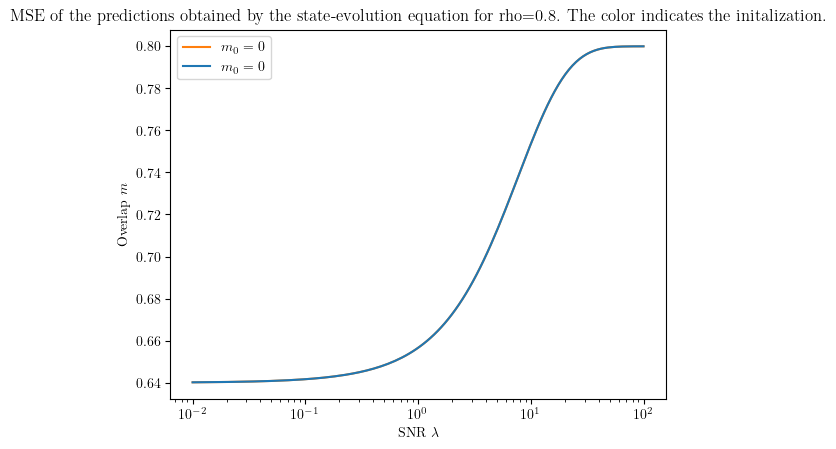

In [ ]:
rho = 0.8
snr_range = np.logspace(-2,2, 128)


se_values_uninf = state_evolve_curve(snr_range=snr_range, 
                    rho=rho,                        
                    init_m=0.0)

plt.plot(np.array(se_values_uninf['snr']), np.array(se_values_uninf['m']), label=r'$m_0=0$', color=colors[1])

se_values_inf = state_evolve_curve(snr_range=snr_range, 
                    rho=rho,
                    init_m=1.0)

plt.plot(np.array(se_values_inf['snr']), np.array(se_values_inf['m']), label=r'$m_0=0$', color=colors[0])
plt.xscale('log')
plt.xlabel(r"SNR $\lambda$")
plt.ylabel(r"Overlap $m$")
# plt.title(f'MSE of the predictions obtained by the state-evolution equation for rho={rho}. The color indicates the initalization.')
plt.legend()

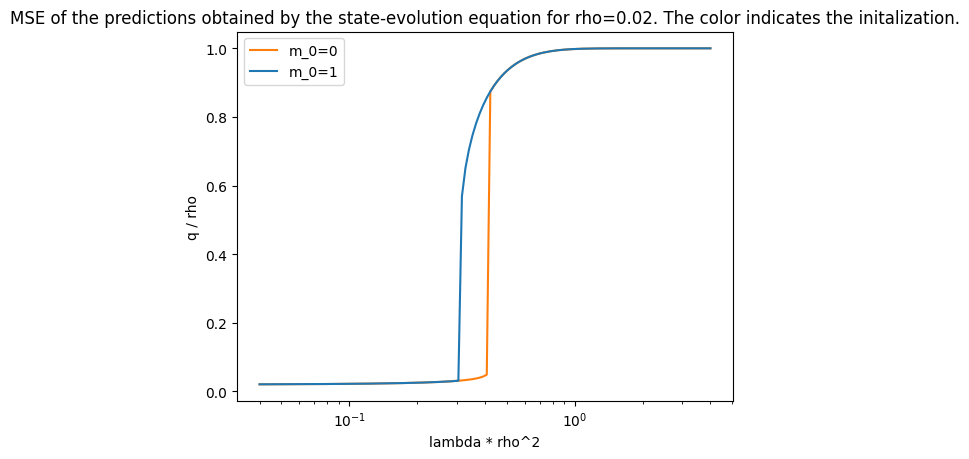

In [35]:
rho = .02
snr_range = np.logspace(2, 4, 128)


se_values_uninf = state_evolve_curve(snr_range=snr_range, 
                    rho=rho,                        
                    init_m=0.0)

plt.plot(np.array(se_values_uninf['snr'])*rho**2, np.array(se_values_uninf['m'])/rho, label='m_0=0', color=colors[1])

se_values_inf = state_evolve_curve(snr_range=snr_range, 
                    rho=rho,
                    init_m=1.0)

plt.plot(np.array(se_values_inf['snr'])*rho**2, np.array(se_values_inf['m'])/rho, label='m_0=1', color=colors[0])
plt.xlabel('lambda * rho^2')
plt.xscale('log')
plt.ylabel('q / rho')
plt.title(f'MSE of the predictions obtained by the state-evolution equation for rho={rho}. The color indicates the initalization.')
plt.legend()